# First part: ridge regression

In [200]:
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
import numpy as np
import math
import sklearn
import random
from sklearn.model_selection import train_test_split, cross_val_score
from numpy import linalg

## Ridge regression

Ridge regression is a type of regression that introduces the concept of regularization through the alpha parameter in the ERM; at the end of this project we will see how to calibrate the value of this parameter

A regressor is a function

<img src = "images/regressor.png" width = "200">

 where <em>w</em> is a vector of real coefficients (weights), and <em>x</em> refers to the <em>x</em> component of training set

As anticipated before, the ERM is regularized by parameter <b>alpha</b>

<img src= "images/ridge_regression.png" width = "350"/>

where S is the <b>design matrix</b>, the matrix of examples without labels

$\nabla(\left \| Sw - y \right \|^2 + \alpha \left \| w \right \|^2) = 2(S^TSw - S^Ty) + 2\alpha w$

since we want to minimize this function, let's set it equal to 0 and we obtain

$(S^TS + \alpha I)w = S^Ty$

$w = (S^TS + \alpha I)^{-1} S^Ty$

The regularization is needed since, without it, the vector is unstable; in particular, it can change a lot when the dataset is perturbed and let's keep in mind that we had to deal with missing values, hence we changed a fex examples and this could have led to a variance error.

### Estimator

In [215]:
class myRidgeRegressor(object):
    
    def __init__(self):
        pass
    
    def fit(self, S, y, alfa):
        self.w = linalg.inv(S.T.dot(S) + alfa * np.eye(S.shape[1])).dot(S.T.dot(y))
    
    def predict(self, x):
        return x.dot(self.w)

In [216]:
def square_loss(prediction, y):
    return (y - prediction) ** 2

In [217]:
def test_error(loss):
    return 1/len(loss) * sum(loss)

### Loading preprocessed datasets

Let's load the preprocessed datasets, we will handle 4 cases:
1. the complete dataset with replaced missing values normalized with min-max
2. the reduced dataset (missing values have been removed) with min-max normalization
3. the complete dataset with z-score normalization
4. the reduced dataset normalized with z-score

In [218]:
min_max_norm_dataset = pd.read_csv("datasets/min_max_norm_dataset")
min_max_norm_reduced_dataset = pd.read_csv("datasets/min_max_norm_reduced_dataset")

zscore_norm_dataset = pd.read_csv("datasets/zscore_norm_dataset")
zscore_norm_reduced_dataset = pd.read_csv("datasets/zscore_norm_reduced_dataset")

In [219]:
del min_max_norm_dataset["Unnamed: 0"]
del min_max_norm_reduced_dataset["Unnamed: 0"]
del zscore_norm_dataset["Unnamed: 0"]
del zscore_norm_reduced_dataset["Unnamed: 0"]

### Splitting in training and test set

In [220]:
def split_dataset(dataset):
    y = dataset["median_house_value"]
    x = dataset.drop("median_house_value", axis = 1)
    return train_test_split(x, y, test_size = 0.2)

Now we apply the ridge regressor for the 4 datasets and compute predictions, for this part it will be used $\alpha$ = 0.1

In [222]:
ridge_regressor = myRidgeRegressor()

### First dataset

In [221]:
x_train, x_test, y_train, y_test = split_dataset(min_max_norm_dataset)

We fit the regressor with the training set, we obtain a w vector of weights that depends on alpha parameter

In [223]:
ridge_regressor.fit(x_train, y_train, 0.1)
ridge_regressor.w

array([-0.14127452, -0.0854095 ,  0.16800738, -0.80357822,  1.21352084,
       -2.8105515 ,  1.09330944,  1.27952936,  0.22083087])

and we can test the regressor on the test set to see how good predictions are done

In [241]:
predictions = ridge_regressor.predict(x_test)
predictions[:10]

14576    0.412276
9813     0.487587
16395    0.230403
1783     0.150503
13363    0.147700
9654     0.074935
4187     0.378733
19496    0.317868
6775     0.461545
10222    0.538990
dtype: float64

In [229]:
loss = square_loss(predictions, y_test)

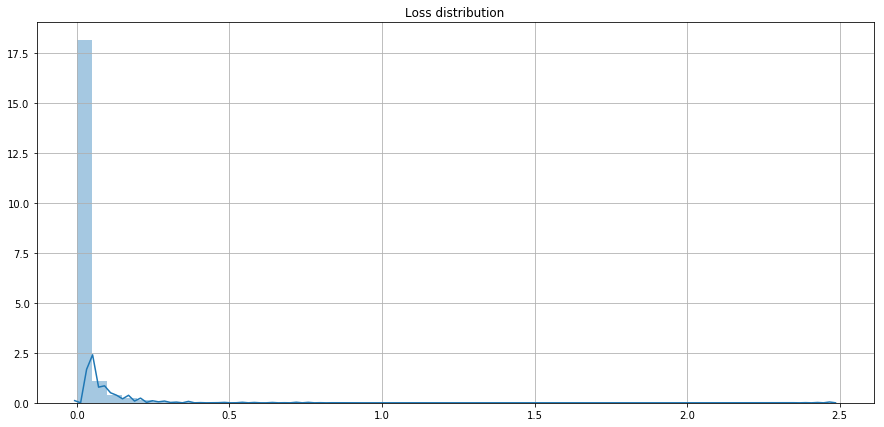

In [230]:
plt.figure(figsize=(15, 7))
plt.title('Loss distribution')
seaborn.distplot(loss.values)
plt.grid()
plt.show()

In [231]:
test_error(loss)

0.021144680327004214

### Second dataset

In [232]:
x_train, x_test, y_train, y_test = split_dataset(min_max_norm_reduced_dataset)

In [233]:
ridge_regressor.fit(x_train, y_train, 0.1)
ridge_regressor.w

array([-0.14536069, -0.08578865,  0.16965325, -0.76418939,  1.22343526,
       -2.64821048,  1.00958835,  1.26497438,  0.22371973])

In [234]:
predictions = ridge_regressor.predict(x_test)
predictions[:10]

14576    0.412276
9813     0.487587
16395    0.230403
1783     0.150503
13363    0.147700
9654     0.074935
4187     0.378733
19496    0.317868
6775     0.461545
10222    0.538990
dtype: float64

In [242]:
loss = square_loss(predictions, y_test)

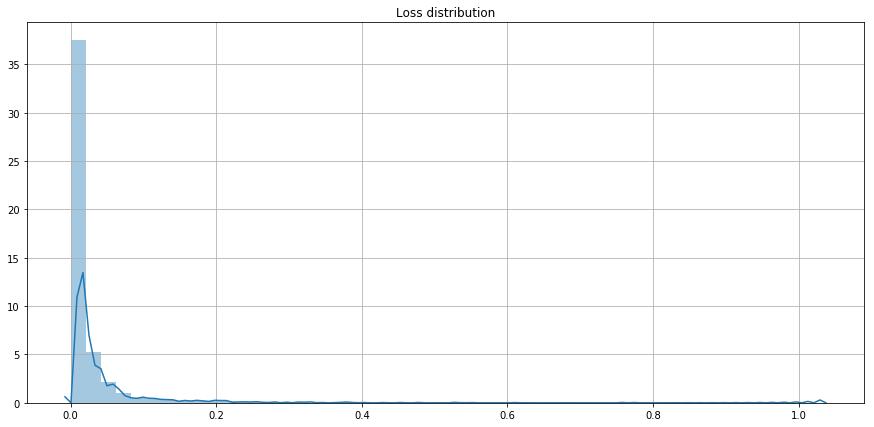

In [243]:
plt.figure(figsize=(15, 7))
plt.title('Loss distribution')
seaborn.distplot(loss.values)
plt.grid()
plt.show()

In [244]:
test_error(loss)

0.020997477568953957

### Third dataset

In [245]:
x_train, x_test, y_train, y_test = split_dataset(zscore_norm_dataset)

In [246]:
ridge_regressor.fit(x_train, y_train, 0.1)
ridge_regressor.w

array([-0.55022982, -0.54996651,  0.1262269 , -0.14619897,  0.37332699,
       -0.37263284,  0.19150627,  0.65596815,  0.12852113])

In [248]:
predictions = ridge_regressor.predict(x_test)
predictions[:10]

3801     0.343197
9129    -0.372180
13388   -0.568454
2110    -0.686184
9805     0.769911
10499   -0.319569
1689     0.287554
5018    -0.783479
10568    1.212194
18056    1.910859
dtype: float64

In [249]:
loss = square_loss(predictions, y_test)

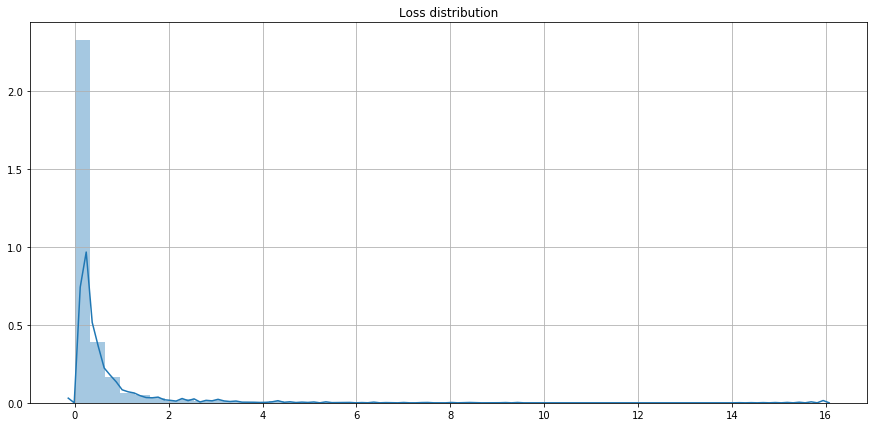

In [250]:
plt.figure(figsize=(15, 7))
plt.title('Loss distribution')
seaborn.distplot(loss.values)
plt.grid()
plt.show()

In [251]:
test_error(loss)

0.35610704733145143

### Fourth dataset

In [252]:
x_train, x_test, y_train, y_test = split_dataset(zscore_norm_reduced_dataset)

In [253]:
ridge_regressor.fit(x_train, y_train, 0.1)
ridge_regressor.w

array([-0.54189949, -0.54490725,  0.12560834, -0.10513403,  0.32195912,
       -0.43611678,  0.25051186,  0.65042652,  0.13054763])

In [258]:
predictions = ridge_regressor.predict(x_test)
predictions[:10]

19763   -1.129630
8751     1.049356
17705    0.038338
13597   -0.838406
8003     0.585036
1866    -1.648437
2884    -1.218145
15476   -0.352318
15946    0.322828
9984     0.596670
dtype: float64

In [259]:
loss = square_loss(predictions, y_test)

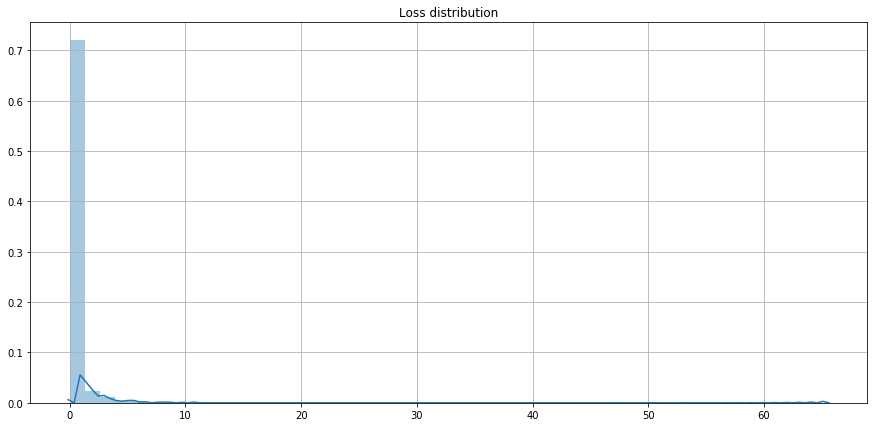

In [260]:
plt.figure(figsize=(15, 7))
plt.title('Loss distribution')
seaborn.distplot(loss.values)
plt.grid()
plt.show()

In [261]:
test_error(loss)

0.3779487652221518

We notice a relevant difference in test error between the first two datasets with respect to the last twos, which reveals that min max normalization produces better result than z-score.
For what it concerns the replacement of missing values, we notice very little difference.

# Second part: analysis

We are dealing with a learning problem $(D, l)$ where $l$ is the square loss:

- Let $h(S)$ be the prediction of predictor $h$ on training set $S$
- Let $l_D(h(S))$ be the risk of $h(S)$
- Let $E[l_D(h)]$ be the expected risk of $h(S)$ where the expectation is with respect to the random draw of training set $S$

Hence, $E[l_D(h)]$ measures the performance of $h$ on a random training set whereas $l_D(h(S))$ measures the performance of $h$ when the training set is $S$

## K-fold cross validation

We would like to estimate $E[l_D(h)]$ to see, in general, the goodness of our predictor; in order to do this, we can use k-fold cross validation:  
let $S$ be the entire dataset, we partition $S$ in $K$ subsets (called folds) $D_1, D_2, ..., D_K$ of size $m/K$ each where $m$ is the size of $S$ and we use $S^{(k)}$ as <b>training part</b> with $S^{(k)} \equiv S \setminus D_k$ where $D_k$ is the <b>testing part</b>;
we iterate this process for $k = 1 ... K$.

In [156]:
m = len(min_max_norm_reduced_dataset)
K = 5

print(m, K)

20640 5


we choose $K$ such that $m$ is divisible with $K$

In [169]:
def k_fold_split(dataset, m, K):
    partitions = {}
    shift = int(m/K)
    pivot = 0
    for i in range(1, K+1):
        partitions[i] = dataset.iloc[pivot : pivot + shift]
        pivot = pivot + shift
    return partitions

In [170]:
partitions = k_fold_split(min_max_norm_reduced_dataset, m, K)

Now that we have $K$ folds we can proceed by iterating over them choosing the training and the testing part

In [183]:
estimation = []

for i in partitions:
    # S^(i) means using fold i as testing part and the rest as training
    testing_part = partitions[i]
    training_part = 

SyntaxError: unexpected EOF while parsing (<ipython-input-183-a957fbe48a38>, line 4)

## Dependence of the cross-validated risk estimate on the parameter alpha

## Using PCA

## optional: try nested CV to avoid choosing alpha